# **SpaceX Falcon9 Launch Trajectory (Booster Recovery)**
(c) 2023 Devakumar Thammisetty

MPOPT is an open-source Multi-phase Optimal Control Problem (OCP) solver based on pseudo-spectral collocation with customized adaptive grid refinement techniques.

https://mpopt.readthedocs.io/

Download this notebook: [falcon9_to_orbit.ipynb](https://github.com/mpopt/mpopt/blob/docs/docs/source/notebooks/falcon9_to_orbit.ipynb)

Install mpopt from pypi using the following. Disable after first usage

Import mpopt (Contains main solver modules)

In [1]:
#!pip install mpopt
from mpopt import mp
import numpy as np
import casadi as ca

### Defining OCP

OCP: (Multi stage launch vehicle OCP : Delta-III rocket)
http://dx.doi.org/10.13140/RG.2.2.19519.79528

   \begin{aligned}
&\!\min_{x, u}        & \qquad & J = -x_6(t_f) + \int_{t_0}^{t_f}0 dt\\
&\text{subject to} &      & \\
&\qquad \text{Define}&      & \mathbf{r} = [x_0, x_1, x_2]; \ \mathbf{v} = [x_3, x_4, x_5]; \ m = x_6; \ \mathbf{u} = [u_0, u_1, u_2];\\
&&      & \mu=3.986012e14;\ \omega_e = [0, 0, 7.29211585e-5]^T;\ R_e = 6378145;\\
&&      & \rho_0=1.225;\ H_0=7200;\ C_d=0.5;\ A^{\text{ref}}=4\pi;\\
&&      & T^0=4854100;\ T^1=2968600;\ T^2=1083100; T^3=110094;\\
&&      & \dot{m}^0=1723.273;\ \dot{m}^1=1044.682;\ \dot{m}^2=366.092;\ \dot{m}^3=24.029;\\
&\quad \textit{Dynamics:} &      & \dot{\mathbf{r}} =  \mathbf{v}\\
&                  &      & \dot{\mathbf{v}} =  -\dfrac{\mu}{|{\mathbf{r}|}^3}\mathbf{r} + \dfrac{T^p}{m}\mathbf{u} - \dfrac{C_dA^{\text{ref}}\rho_0|{\mathbf{v}-(\omega_e\times \mathbf{r})}|(\mathbf{v}-(\omega_e\times \mathbf{r}))e^{\frac{|{\mathbf{r}}|-R_e}{H_0}}}{2m}\\
& &      & \dot{m} = -\dot{m}^p \qquad \qquad p = 0, 1, 2, 3\\
& \quad \textit{Path constraints: } &      & |{\mathbf{u}}| = 1 \\
&                  &      & |{\mathbf{r}}| \geq R_e \\
& \quad \textit{Terminal constraints: } & & t_0^0 =0;\ t_0^1 = 75.2;\ t_0^2=150.4;\ t_0^3 = 261   \\
&                  & & t_f^0 =75.2;\ t_f^1 = 150.4;\ t_f^2=261 \\
&&      & \text{Let}\ \mathbf{r_f} = [x_0(t_f^3), x_1(t_f^3), x_2(t_f^3)]; \ \mathbf{v_f} = [x_3(t_f^3), x_4(t_f^3), x_5(t_f^3)];\\
&                  & & a_f(\mathbf{r_f}, \mathbf{v_f}) = 24361140; e_f(\mathbf{r_f}, \mathbf{v_f}) = 0.7308; \\
&                  & & i_f(\mathbf{r_f}, \mathbf{v_f}) = \frac{28.5\pi}{180}; \Omega_f(\mathbf{r_f}, \mathbf{v_f}) = \frac{269.8\pi}{180}; \\
&                  & & \omega_f(\mathbf{r_f}, \mathbf{v_f}) = \frac{130.5\pi}{180};  \\
&                  & & \text{Where}\ a_f, e_f, i_f, \Omega_f, \omega_f\ \text{are computed as follows}\\
&                  & & \mathbf{h} = \mathbf{r_f}\times \mathbf{v_f};\ \mathbf{n} = [0, 0, 1]^T\times \mathbf{v_f};\\
&                  & & \mathbf{e} = \frac{1}{\mu}\mathbf{v_f}\times \mathbf{h} - \dfrac{\mathbf{r_f}}{|{\mathbf{r_f}}|};\\
&                  & &e_f = |{\mathbf{e}}|;\ a_f = -\dfrac{\mu}{|{\mathbf{v_f}}|^2-\frac{2\mu}{|{\mathbf{r_f}}|}};\ i_f = \cos^{-1}\left(\dfrac{\mathbf{h}.[0, 0, 1]^T}{|{\mathbf{h}}|}\right);\\
&                  & & \text{if }\mathbf{n}[1]\text{>0:}\ \Omega_f = \cos^{-1}\left(\dfrac{\mathbf{n}.[0, 0, 1]^T}{|{\mathbf{n}}|}\right)\ \text{else:}\ \Omega_f = (2\pi - \Omega_f);\\
&                  & & \text{if e[2]>0:}\ \omega_f = \cos^{-1}\left(\dfrac{\mathbf{n}.\mathbf{e}}{|{\mathbf{n}}|e_f}\right)\ \text{else:}\ \omega_f = (2\pi - \omega_f);\\
& \quad \textit{Event constraints: } &      &  \mathbf{r}(t_f^p) - \mathbf{r}(t_0^{p+1}) = 0; \ \mathbf{v}(t_f^{p}) - \mathbf{v}(t_0^{p+1}) = 0; \quad p = 0, 1, 2\\
&  &      & m(t_f^p) - m(t_0^{p+1}) = [13680, 6840, 8830]\quad p = 0, 1, 2\\
& \quad \textit{Initial conditions: } &      &  \mathbf{r}(t_0^0) = [5605222.973, 0, 3043387.761]; \mathbf{v}(t_0^{0}) = [0, 408.74, 0];\\
&  &      & m(t_0^0) = 301454
  \end{aligned}


We first create an OCP object and then polulate the object with dynamics, path_constraints, terminal_constraints and objective (running_costs, terminal_costs)

In [2]:
ocp = mp.OCP(n_states=7, n_controls=4, n_phases=3)

In [3]:
# Initialize parameters
Re = 6378145.0  # m
omegaE = 7.29211585e-5
rho0 = 1.225
rhoH = 7200.0
Sa = 4 * np.pi
Cd = 0.5
muE = 3.986012e14
g0 = 9.80665

# Variable initialization
lat0 = 28.5 * np.pi / 180.0
r0 = np.array([Re * np.cos(lat0), 0.0, Re * np.sin(lat0)])
# v0     = omegaE*np.array([-r0[1], r0[0], 0.0])
v0 = omegaE * np.array([0.1, 0.1, 0.1])
m0 = 431.6e3 + 107.5e3
mf = 107.5e3 - 103.5e3
mdryBooster = 431.6e3 - 409.5e3
mdrySecond = mf
x0 = np.array([r0[0], r0[1], r0[2], v0[0], v0[1], v0[2], m0])
q_max = 80 * 1e3

In [4]:
# Step-1 : Define dynamics
# Thrust(N) and mass flow rate(kg/s) in each stage
Thrust = [9 * 934.0e3, 934.0e3, 934.0e3]


def stage_dynamics(x, u, t, param=0, T=0.0):
    r = x[:3]
    v = x[3:6]
    m = x[6]
    r_mag = ca.sqrt(r[0] * r[0] + r[1] * r[1] + r[2] * r[2])
    v_rel = v  # ca.vertcat(v[0] + r[1] * omegaE, v[1] - r[0] * omegaE, v[2])
    v_rel_mag = ca.sqrt(v_rel[0] * v_rel[0] + v_rel[1] * v_rel[1] + v_rel[2] * v_rel[2])
    h = r_mag - Re
    rho = rho0 * ca.exp(-h / rhoH)
    D = -rho / (2 * m) * Sa * Cd * v_rel_mag * v_rel
    g = -muE / (r_mag * r_mag * r_mag) * r

    xdot = [
        x[3],
        x[4],
        x[5],
        T * u[3] / m * u[0] + param * D[0] + g[0],
        T * u[3] / m * u[1] + param * D[1] + g[1],
        T * u[3] / m * u[2] + param * D[2] + g[2],
        -T * u[3] / (340.0 * g0),
    ]
    return xdot


def get_dynamics(param):
    dynamics0 = lambda x, u, t: stage_dynamics(x, u, t, param=param, T=Thrust[0])
    dynamics1 = lambda x, u, t: stage_dynamics(x, u, t, param=param, T=Thrust[1])
    dynamics2 = lambda x, u, t: stage_dynamics(x, u, t, param=param, T=Thrust[2])

    return [dynamics0, dynamics1, dynamics2]


ocp.dynamics = get_dynamics(0)

In [5]:
# Step-2: Add path constraints
def path_constraints0(x, u, t):
    return [
        u[0] * u[0] + u[1] * u[1] + u[2] * u[2] - 1,
        -u[0] * u[0] - u[1] * u[1] - u[2] * u[2] + 1,
        -ca.sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2]) / Re + 1,
    ]


def path_constraints2(x, u, t, dynP=0, gs=0):
    r_mag = ca.sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2])
    h = r_mag - Re
    rho = rho0 * ca.exp(-h / rhoH)
    v_sq = x[3] * x[3] + x[4] * x[4] + x[5] * x[5]
    r_rf = ca.vertcat(x[0] - x0[0], x[1] - x0[1], x[2] - x0[2])
    r_rf_mag = ca.sqrt(r_rf[0] * r_rf[0] + r_rf[1] * r_rf[1] + r_rf[2] * r_rf[2])
    rf_mag = np.sqrt(x0[0] * x0[0] + x0[1] * x0[1] + x0[2] * x0[2])
    glide_slope_factor = np.cos(80.0 * np.pi / 180.0)

    return [
        dynP * 0.5 * rho * v_sq / q_max - 1.0,
        u[0] * u[0] + u[1] * u[1] + u[2] * u[2] - 1,
        -u[0] * u[0] - u[1] * u[1] - u[2] * u[2] + 1,
        -ca.sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2]) / Re + 1,
        gs
        * (
            r_rf_mag * glide_slope_factor
            - (r_rf[0] * x0[0] + r_rf[1] * x0[1] + r_rf[2] * x0[2]) / rf_mag
        ),
    ]


ocp.path_constraints = [path_constraints0, path_constraints0, path_constraints2]

In [6]:
# Step-3: Add terminal cost and constraints
def terminal_cost1(xf, tf, x0, t0):
    return -xf[6] / m0


ocp.terminal_costs[1] = terminal_cost1


def terminal_constraints1(x, t, x0, t0):
    h = ca.vertcat(
        x[1] * x[5] - x[4] * x[2], x[3] * x[2] - x[0] * x[5], x[0] * x[4] - x[1] * x[3]
    )

    n = ca.vertcat(-h[1], h[0], 0)
    r = ca.sqrt(x[0] * x[0] + x[1] * x[1] + x[2] * x[2])

    e = ca.vertcat(
        1 / muE * (x[4] * h[2] - x[5] * h[1]) - x[0] / r,
        1 / muE * (x[5] * h[0] - x[3] * h[2]) - x[1] / r,
        1 / muE * (x[3] * h[1] - x[4] * h[0]) - x[2] / r,
    )

    e_mag = ca.sqrt(e[0] * e[0] + e[1] * e[1] + e[2] * e[2])
    h_sq = h[0] * h[0] + h[1] * h[1] + h[2] * h[2]
    v_mag = ca.sqrt(x[3] * x[3] + x[4] * x[4] + x[5] * x[5])

    a = -muE / (v_mag * v_mag - 2.0 * muE / r)
    i = ca.acos(h[2] / ca.sqrt(h_sq))
    n_mag = ca.sqrt(n[0] * n[0] + n[1] * n[1])

    node_asc = ca.acos(n[0] / n_mag)
    # if n[1] < -1e-12:
    node_asc = 2 * np.pi - node_asc

    argP = ca.acos((n[0] * e[0] + n[1] * e[1]) / (n_mag * e_mag))
    # if e[2] < 0:
    #    argP = 2*np.pi - argP

    a_req = 6593145.0  # 24361140.0
    e_req = 0.0076
    i_req = 28.5 * np.pi / 180.0
    node_asc_req = 269.8 * np.pi / 180.0
    argP_req = 130.5 * np.pi / 180.0

    return [
        (a - a_req) / (Re),
        e_mag - e_req,
        i - i_req,
        node_asc - node_asc_req,
        argP - argP_req,
    ]


def terminal_constraints2(x, t, x_0, t_0):
    return [
        (x[0] - x0[0]) / Re,
        (x[1] - x0[1]) / Re,
        (x[2] - x0[2]) / Re,
        (x[3] - x0[3]) / np.sqrt(muE / Re),
        (x[4] - x0[4]) / np.sqrt(muE / Re),
        (x[5] - x0[5]) / np.sqrt(muE / Re),
    ]


ocp.terminal_constraints[1] = terminal_constraints1
ocp.terminal_constraints[2] = terminal_constraints2

Scale the variables

In [7]:
ocp.scale_x = np.array(
    [
        1 / Re,
        1 / Re,
        1 / Re,
        1 / np.sqrt(muE / Re),
        1 / np.sqrt(muE / Re),
        1 / np.sqrt(muE / Re),
        1 / m0,
    ]
)
ocp.scale_t = np.sqrt(muE / Re) / Re

Initial state and Final guess

In [8]:
# Initial guess estimation
# User defined functions
def ae_to_rv(a, e, i, node, argP, th):
    p = a * (1.0 - e * e)
    r = p / (1.0 + e * np.cos(th))

    r_vec = np.array([r * np.cos(th), r * np.sin(th), 0.0])
    v_vec = np.sqrt(muE / p) * np.array([-np.sin(th), e + np.cos(th), 0.0])

    cn, sn = np.cos(node), np.sin(node)
    cp, sp = np.cos(argP), np.sin(argP)
    ci, si = np.cos(i), np.sin(i)

    R = np.array(
        [
            [cn * cp - sn * sp * ci, -cn * sp - sn * cp * ci, sn * si],
            [sn * cp + cn * sp * ci, -sn * sp + cn * cp * ci, -cn * si],
            [sp * si, cp * si, ci],
        ]
    )

    r_i = np.dot(R, r_vec)
    v_i = np.dot(R, v_vec)

    return r_i, v_i


# Target conditions
a_req = 6593145.0  # 24361140.0
e_req = 0.0076
i_req = 28.5 * np.pi / 180.0
node_asc_req = 269.8 * np.pi / 180.0
argP_req = 130.5 * np.pi / 180.0
th = 0.0
rf, vf = ae_to_rv(a_req, e_req, i_req, node_asc_req, argP_req, th)
xf = np.array([rf[0], rf[1], rf[2], vf[0], vf[1], vf[2], mf])

Intial guess

In [9]:
# Timings
# Timings
t0, t1, t2, t3 = 0.0, 131.4, 453.4, 569.7

# Interpolate to get starting values for intermediate phases
x1 = x0 + (xf - x0) / (t2 - t0) * (t1 - t0)

# Update the state discontinuity values across phases
x0f = np.copy(x1)
x0f[-1] = x0[-1] - (9 * 934e3 / (340.0 * g0) * t1)
mFirst_leftout = 409.5e3 - (9 * 934e3 / (340.0 * g0) * t1)
x1[-1] = x0f[-1] - (mdryBooster + mFirst_leftout)

# Step-8b: Initial guess for the states, controls and phase start and final
#             times
ocp.x00 = np.array([x0, x1, x0f])
ocp.xf0 = np.array([x0f, xf, x0])
ocp.u00 = np.array([[1, 0, 0, 1.0], [1, 0, 0, 1], [0, 1, 0, 1]])
ocp.uf0 = np.array([[0, 1, 0, 1.0], [0, 1, 0, 1], [1, 0, 0, 0.5]])
ocp.t00 = np.array([[t0], [t1], [t1]])
ocp.tf0 = np.array([[t1], [t2], [t3]])

Box constraints

In [10]:
# Step-8c: Bounds for states
rmin, rmax = -2 * Re, 2 * Re
vmin, vmax = -10000.0, 10000.0

lbx0 = [rmin, rmin, rmin, vmin, vmin, vmin, x0f[-1]]
lbx1 = [rmin, rmin, rmin, vmin, vmin, vmin, xf[-1]]
lbx2 = [rmin, rmin, rmin, vmin, vmin, vmin, mdryBooster]
ubx0 = [rmax, rmax, rmax, vmax, vmax, vmax, x0[-1]]
ubx1 = [rmax, rmax, rmax, vmax, vmax, vmax, 107.5e3]
ubx2 = [rmax, rmax, rmax, vmax, vmax, vmax, x0f[-1] - 107.5e3]

ocp.lbx = np.array([lbx0, lbx1, lbx2])
ocp.ubx = np.array([ubx0, ubx1, ubx2])

# Bounds for control inputs
ocp.lbu = np.array(
    [[-1.0, -1.0, -1.0, 1.0], [-1.0, -1.0, -1.0, 1.0], [-1.0, -1.0, -1.0, 0.38]]
)
ocp.ubu = np.array([[1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0]])

# Bounds for phase start and final times
ocp.lbt0 = np.array([[t0], [t1], [t1]])
ocp.ubt0 = np.array([[t0], [t1], [t1]])
ocp.lbtf = np.array([[t1], [t2 - 50], [t3 - 100]])
ocp.ubtf = np.array([[t1], [t2 + 50], [t3 + 100]])

# Event constraint bounds on states : State continuity/disc.
lbe0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -(mdryBooster + mFirst_leftout)]
lbe1 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -107.5e3]
ocp.lbe = np.array([lbe0, lbe1])
ocp.ube = np.array([lbe0, lbe1])

ocp.phase_links = [(0, 1), (0, 2)]

In [11]:
ocp.validate()

### Solve with atmospheric drag disabled 

In [12]:
ocp.dynamics = get_dynamics(0)
mpo = mp.mpopt(ocp, 5, 6)
sol = mpo.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Total number of variables............................:      956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      956
                     variables with only upper bounds:        0
Total number of equality constraints.................:      746
Total number of inequality constraints...............:      641
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      341


Number of Iterations....: 153

   

Solve the problem with drag enabled now with revised initial guess

In [13]:
ocp.dynamics = get_dynamics(1)
ocp.path_constraints[2] = lambda x, u, t: path_constraints2(x, u, t, dynP=1, gs=0)
ocp.validate()

mpo._ocp = ocp
sol = mpo.solve(
    sol, reinitialize_nlp=True, nlp_solver_options={"ipopt.acceptable_tol": 1e-6}
)

Total number of variables............................:      956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      956
                     variables with only upper bounds:        0
Total number of equality constraints.................:      746
Total number of inequality constraints...............:      641
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      300
        inequality constraints with only upper bounds:      341


Number of Iterations....: 61

                                   (scaled)                 (unscaled)
Objective...............:  -3.1423421485119993e-02   -3.1423421485119993e-02
Dual infeasibility......:   6.7634340985309009e-12    6.7634340985309009e-12
Constraint violation....:   1.9999893324795792e-08    1.9999893324795792e-08
Complementarity.........:   9.1006695117999755e-10    9.1006695117999755e-10
Overall NLP e

Retrive data from the solution

In [14]:
post = mpo.process_results(sol, plot=False, scaling=False)
mp.post_process._INTERPOLATION_NODES_PER_SEG = 200
x, u, t, _ = post.get_data(phases=ocp.phase_links[0], interpolate=False)
print("Payload:\nMass to orbit : ", round(x[-1][-1], 4), "kg(MPOPT) vs 17310kg(Beigler paper)")
print("Time to orbit (SECO) : ", round(t[-1][0], 4), "s(MPOPT) vs 453.4s(Beigler paper)")
x, u, t, _ = post.get_data(phases=ocp.phase_links[1], interpolate=False)
print("\nBooster:\n Mass at landing : ", round(x[-1][-1], 4), "kg(MPOPT) vs 22100kg(Beigler paper)")
print("Time of landing : ", round(t[-1][0], 4), "s(MPOPT) vs 569.7s(Beigler paper)")

Payload:
Mass to orbit :  16940.3665 kg(MPOPT) vs 17310kg(Beigler paper)
Time to orbit (SECO) :  454.6864 s(MPOPT) vs 453.4s(Beigler paper)

Booster:
 Mass at landing :  22100.0 kg(MPOPT) vs 22100kg(Beigler paper)
Time of landing :  579.5091 s(MPOPT) vs 569.7s(Beigler paper)


### Plot results

Plot trajectory of launch to orbit (Second stage) and Booster return to Ship.

[Text(0, 0.5, 'Velocity, km/s')]

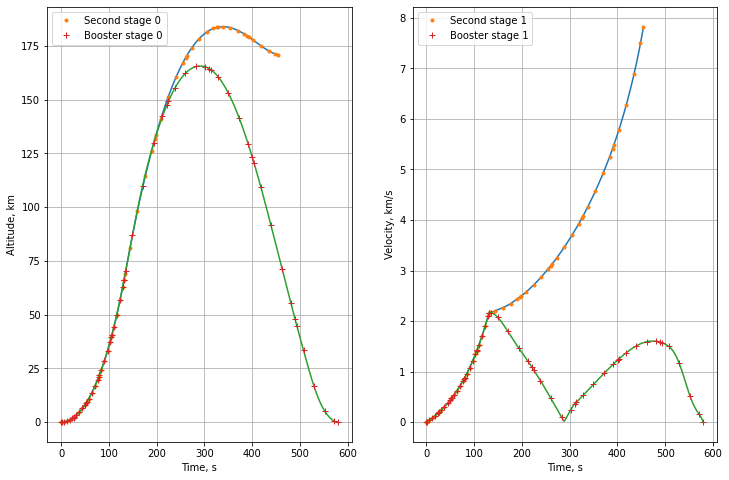

In [15]:
mp.plt.rcParams["figure.figsize"] = (12,8)
x0, u0, t0, _ = post.get_data(phases=ocp.phase_links[0], interpolate=True)
x1, u1, t1, _ = post.get_data(phases=ocp.phase_links[1], interpolate=True)
x0o, u0o, t0o, _ = post.get_data(phases=ocp.phase_links[0], interpolate=False)
x1o, u1o, t1o, _ = post.get_data(phases=ocp.phase_links[1], interpolate=False)

r0 = 1e-3 * (np.sqrt(x0[:, 0] ** 2 + x0[:, 1] ** 2 + x0[:, 2] ** 2) - Re)
v0 = 1e-3 * np.sqrt(x0[:, 3] ** 2 + x0[:, 4] ** 2 + x0[:, 5] ** 2)
y0 = np.column_stack((r0, v0))
fig0, axs0 = post.plot_single_variable(y0, t0, [[0], [1]], axis=0)

r0o = 1e-3 * (np.sqrt(x0o[:, 0] ** 2 + x0o[:, 1] ** 2 + x0o[:, 2] ** 2) - Re)
v0o = 1e-3 * np.sqrt(x0o[:, 3] ** 2 + x0o[:, 4] ** 2 + x0o[:, 5] ** 2)
y0o = np.column_stack((r0o, v0o))
fig0o, axs0o = post.plot_single_variable(
    y0o,
    t0o,
    [[0], [1]],
    axis=0,
    fig=fig0,
    axs=axs0,
    tics=["."] * 15,
    name="Second stage",
)

r1 = 1e-3 * (np.sqrt(x1[:, 0] ** 2 + x1[:, 1] ** 2 + x1[:, 2] ** 2) - Re)
v1 = 1e-3 * np.sqrt(x1[:, 3] ** 2 + x1[:, 4] ** 2 + x1[:, 5] ** 2)
y1 = np.column_stack((r1, v1))
fig1, axs1 = post.plot_single_variable(y1, t1, [[0], [1]], axis=0, fig=fig0o, axs=axs0o)

r1o = 1e-3 * (np.sqrt(x1o[:, 0] ** 2 + x1o[:, 1] ** 2 + x1o[:, 2] ** 2) - Re)
v1o = 1e-3 * np.sqrt(x1o[:, 3] ** 2 + x1o[:, 4] ** 2 + x1o[:, 5] ** 2)
y1o = np.column_stack((r1o, v1o))
fig1o, axs1o = post.plot_single_variable(
    y1o,
    t1o,
    [[0], [1]],
    axis=0,
    fig=fig1,
    axs=axs1,
    tics=["+"] * 15,
    name="Booster stage",
)

axs1o[0].set(ylabel="Altitude, km")
axs1o[1].set(ylabel="Velocity, km/s")